In [141]:
#import face_recognition as fr
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import pandas as pd
import cv2
from os import remove
face_cascade = cv2.CascadeClassifier('gui_2/assets/haarcascade_frontalface_default.xml')
HEIGHT, WIDTH =48,48
other_emotions =  [ 'fear', 'disgust','anger']
initial_emotions = ['sadness','happiness', 'surprise', 'neutral']

In [142]:
def get_emotion(x,initial):
    if initial:
        if x in initial_emotions:
            return x
        else:
            return "other"
    else: 
        if x in other_emotions:
            return x

In [143]:
paths = ["data/all/train/","data/all/test/"]#["data/CK_cut/"]#["data/all/train/","data/all/test/"]# #["data/CK+/","data/fer/train/"]
# data  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs = []
state = []

## Datos para entrenar emociones iniciales

In [144]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            if item in initial_emotions:
                imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
                state.extend([item for p in listdir(f"{path}{item}")])
#             else:
#                 imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
#                 state.extend(["other" for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness
surprise
disgust
anger
neutral
happiness
fear
sadness


In [145]:
len(state),len(imgs)

(39562, 39562)

In [108]:
set(state)


{'fear', 'happiness', 'neutral', 'sadness', 'surprise'}

## Datos para entrenar resto emociones 

In [7]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            if item in other_emotions:
                imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
                state.extend([item for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness


In [8]:
len(imgs),set(state)

(1470,
 {'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'})

## *********************************************************

In [146]:
errs = []
try:
    imgs_ = []
    for p in imgs:
        temp = Image.open(p)
        save = temp.copy()
        imgs_.append(save)
        temp.close()
except:
    errs.append(p)

In [147]:
imgs_array = []
HEIGHT, WIDTH =48,48
for f in imgs_:
    img = f.convert("L").resize((HEIGHT, WIDTH))
    imgs_array.append(np.array(img))

In [148]:
imgs_array = [el/255 for el in imgs_array]
imgs_array = np.array(imgs_array)

In [149]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

In [150]:
imgs_array.shape

(39562, 48, 48, 1)

## Con este modo de cargar imagenes, filtramos caras con cv2

In [ ]:

imgs = []
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            imgs.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])

In [ ]:
imgs_ = []
state = []
for p in imgs:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.1, 5) #1.1 factor scale, cuanto  disminuye imagen entre pasos
                                                        #5 MIN nEIGHBORS cuantos vecinos cada posible 
                                                        # rectangulo considerar para prediccion
                                                        # (valor minimo px de la cara detectada)
                                                        # (valor maximo px)
            
    if len(faces)==1:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_.append(recortada)
            state.append(p["emotion"])
    
        
imgs_ = [el/255 for el in imgs_]
imgs_array = np.array(imgs_)


In [ ]:
imgs_array.shape

In [ ]:
set(state)

In [ ]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

# Preparamos entrenamiento

In [151]:
y=pd.DataFrame(state)
y_dummies = pd.get_dummies(y)

In [152]:
y_dummies

,0_happiness,0_neutral,0_sadness,0_surprise
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
39557,0,0,1,0
39558,0,0,1,0
39559,0,0,1,0
39560,0,0,1,0


In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs_array,y_dummies)

In [154]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,BatchNormalization,Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback
import keras

# MODELO 1

In [155]:
model = Sequential()
# 1-conv
model.add(Conv2D(64,(3,3),padding='same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2-conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(len(set(state)),activation='softmax'))

opt = Adam(learning_rate=0.0005)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()


# MODELO 2

In [ ]:
model = Sequential()
#model.add(Flatten())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(imgs_array.shape[1:])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(imgs_array.shape[1:])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(len(set(state), activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

In [72]:
# epochs = 200
# # steps_per_epoch = train_generator.n//train_generator.batch_size
# # validation_steps = validation_generator.n//validation_generator.batch_size

# checkpoint = ModelCheckpoint("modelo_ck_fc_tfeid_p1.h5",monitor='val_accuracy',
#                             save_weights_only=False,save_best_only=True, model='max',verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_lr=0.000001,model='auto')

# callbacks = [PlotLossesCallback(),checkpoint,reduce_lr]
# history = model.fit(X_train,y_train,
#     epochs=epochs,
#     validation_data=(X_test,y_test),
#     callbacks=callbacks
# )

In [156]:
from keras.models import Sequential, load_model, model_from_json
from keras import callbacks, optimizers
import tensorflow as tf
from datetime import date

fecha=str(date.today().year)+str(date.today().month)+str(date.today().day)    
symbol = 'no_dig_no_fear'
h5 = symbol + fecha + '_v1.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                       monitor='loss',
                                       verbose=0,
                                       save_best_only=True,
                                       #save_weights_only=True,
                                       mode='auto',
                                       save_freq=1)
callback = [checkpoint]

modelo = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 5000,callbacks = callback,validation_split = 0.1)

Epoch 1/5000
835/835 [==============================] - 273s 326ms/step - loss: 1.0624 - accuracy: 0.5659 - val_loss: 0.8499 - val_accuracy: 0.6365
Epoch 2/5000
835/835 [==============================] - 10s 12ms/step - loss: 0.7629 - accuracy: 0.6950 - val_loss: 0.8073 - val_accuracy: 0.6944
Epoch 3/5000
835/835 [==============================] - 12s 15ms/step - loss: 0.6802 - accuracy: 0.7292 - val_loss: 0.6985 - val_accuracy: 0.7099
Epoch 4/5000
835/835 [==============================] - 11s 13ms/step - loss: 0.6246 - accuracy: 0.7521 - val_loss: 0.5888 - val_accuracy: 0.7564
Epoch 5/5000
835/835 [==============================] - 11s 13ms/step - loss: 0.5924 - accuracy: 0.7661 - val_loss: 0.8593 - val_accuracy: 0.6395
Epoch 6/5000
835/835 [==============================] - 9s 11ms/step - loss: 0.5671 - accuracy: 0.7766 - val_loss: 1.2080 - val_accuracy: 0.4057
Epoch 7/5000
835/835 [==============================] - 10s 12ms/step - loss: 0.5443 - accuracy: 0.7823 - val_loss: 0.7929 

KeyboardInterrupt: 

In [157]:
paths = ["data/predict/"]
# data_pred  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs_pred = []
state_pred = []
im_pred = {}

In [158]:
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            if item in initial_emotions:
                imgs_pred.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])
                #state_pred.extend([item for p in listdir(f"{path}{item}")])



In [159]:
len(imgs_pred)

74

In [160]:
from keras.models import load_model

In [161]:
#model = load_model('intial_emotions_2_20211116_v1.h5')

In [162]:
imgs_pred_ = []
state_pred = []
for p in imgs_pred:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.05, 5)
    if len(faces)>0:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_pred_.append(recortada)
            state_pred.append(p["emotion"])
    
        
imgs_pred_ = [el/255 for el in imgs_pred_]
imgs_pred_ = np.array(imgs_pred_)
imgs_pred_= imgs_pred_.reshape((len(imgs_pred_),48,48,1))

In [163]:
len(imgs_pred_)

79

In [164]:
len(state_pred)

79

In [165]:
prediction = model.predict(imgs_pred_)

In [166]:
state_pred

['surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 's

In [167]:
prediction[:5]

array([[9.6455386e-09, 2.5123241e-05, 6.9271401e-08, 9.9997473e-01],
       [2.6155356e-05, 1.2993286e-05, 9.7351753e-05, 9.9986351e-01],
       [9.9945217e-01, 1.1151942e-05, 3.2062712e-12, 5.3664343e-04],
       [5.9360741e-07, 5.3291876e-07, 6.7491318e-10, 9.9999893e-01],
       [4.0267386e-07, 8.5783859e-06, 3.7258883e-06, 9.9998736e-01]],
      dtype=float32)

In [168]:
prediction.argmax(axis = -1)


array([3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1])

In [169]:
cats= y_dummies.columns
cats = [x.replace("0_","") for x in cats]

In [170]:
cats

['happiness', 'neutral', 'sadness', 'surprise']

In [171]:
len(prediction)

79

In [172]:
states_model = []
i=0
for i in range(len(prediction)):
    states_model.append(cats[prediction[i].argmax()])
    print(state_pred[i],cats[prediction[i].argmax()])

surprise surprise
surprise surprise
surprise happiness
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
neutral neutral
neutral neutral
neutral neutral
neutral neutral
neutral neutral
neutral sadness
neutral neutral
neutral neutral
neutral neutral
neutral neutral
neutral neutral
neutral happiness
neutral happiness
neutral happiness
neutral neutral
neutral neutral
neutral sadness
neutral happiness
neutral neutral
neutral neutral
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness happiness
happiness sadness
happiness happiness
happiness happiness
happiness happiness
happiness happi

In [173]:
from sklearn.metrics import accuracy_score

In [174]:
accuracy_score(state_pred,states_model)

0.810126582278481

In [175]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


In [176]:
conf = confusion_matrix(states_model, state_pred)
conf = pd.DataFrame(conf,columns=cats, index=cats)

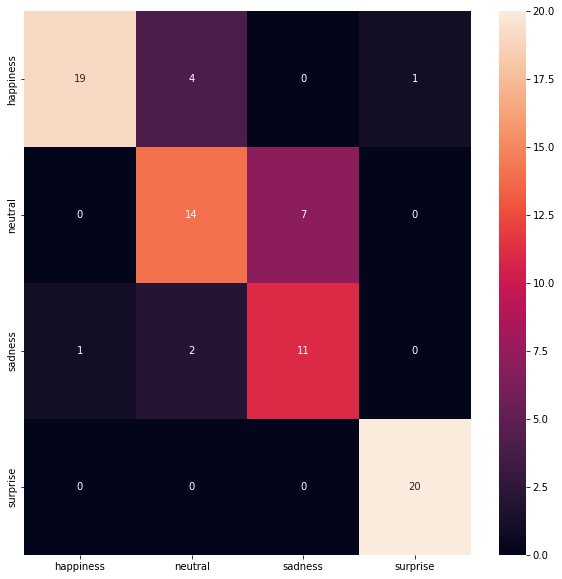

In [177]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(conf, annot=True)

